In [42]:
import struct
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from abc import ABC, abstractmethod

In [43]:
class DataHandler:
    def __init__(self, train_image_path, train_label_path, test_image_path, test_label_path, image_size=(20, 20)):
        self.train_image_path = train_image_path
        self.train_label_path = train_label_path
        self.test_image_path = test_image_path
        self.test_label_path = test_label_path
        self.image_size = image_size

    def read_mnist_images(self, image_file_path, num_images):
        with open(image_file_path, 'rb') as file:
            _, _, rows, cols = struct.unpack(">IIII", file.read(16))
            images = np.fromfile(file, dtype=np.uint8).reshape(num_images, rows, cols)
        return images

    def read_mnist_labels(self, label_file_path, num_labels):
        with open(label_file_path, 'rb') as file:
            _, _ = struct.unpack(">II", file.read(8))
            labels = np.fromfile(file, dtype=np.uint8).reshape(num_labels)
        return labels

    def resize_images(self, images):
        resized_images = np.zeros((images.shape[0], self.image_size[0] * self.image_size[1]), dtype=np.uint8)
        for i, img in enumerate(images):
            img_pil = Image.fromarray(img)
            resized_img_pil = img_pil.resize(self.image_size)
            resized_images[i] = np.array(resized_img_pil).flatten()
        return resized_images

    def select_samples(self, images, labels, num_samples_per_digit=10):
        selected_images = []
        selected_labels = []
        for digit in range(10):
            digit_indices = np.where(labels == digit)[0]
            selected_indices = np.random.choice(digit_indices, num_samples_per_digit, replace=False)
            for idx in selected_indices:
                selected_images.append(images[idx])
                selected_labels.append(labels[idx])
        return np.array(selected_images), np.array(selected_labels)

    def load_data(self):
        train_images = self.read_mnist_images(self.train_image_path, 60000)
        train_labels = self.read_mnist_labels(self.train_label_path, 60000)
        test_images = self.read_mnist_images(self.test_image_path, 10000)
        test_labels = self.read_mnist_labels(self.test_label_path, 10000)

        train_images_resized = self.resize_images(train_images)
        test_images_resized = self.resize_images(test_images)

        return train_images_resized, train_labels, test_images_resized, test_labels
    
    def load_data_subset(self, num_samples_per_digit=10):
        # Read the full dataset
        full_train_images = self.read_mnist_images(self.train_image_path, 60000)
        full_train_labels = self.read_mnist_labels(self.train_label_path, 60000)

        # Resize the images
        full_train_images_resized = self.resize_images(full_train_images)

        # Select a subset of the data
        train_images_subset, train_labels_subset = self.select_samples(full_train_images_resized, full_train_labels, num_samples_per_digit)

        return train_images_subset, train_labels_subset


In [44]:
class ImageVisualizer:
    @staticmethod
    def display_images(images, labels, num_rows=10, num_cols=10, image_shape=(20, 20)):
        plt.figure(figsize=(10, 10))
        for i in range(num_rows * num_cols):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            image_2d = images[i].reshape(image_shape)
            plt.imshow(image_2d, cmap=plt.cm.binary)
            plt.xlabel(labels[i])
        plt.show()
        
    @staticmethod
    def display_images_with_predictions(images, actual_labels, predicted_labels, num_rows=10, num_cols=10, image_shape=(20, 20)):
        plt.figure(figsize=(15, 15))
        for i in range(num_rows * num_cols):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)

            image_2d = images[i].reshape(image_shape)
            plt.imshow(image_2d, cmap=plt.cm.binary)

            plt.xlabel(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}", fontsize=9)
        plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.9,
                            top=0.9,
                            wspace=0.4,
                            hspace=0.6)
        plt.show()

In [45]:
# --- InputData Class ---
class InputData:
    def __init__(self, directory):
        self.directory = directory

    def load_images(self):
        data = []
        labels = []
        for filename in os.listdir(self.directory):
            if filename.endswith('.png'):
                label = int(filename.split('_')[0])
                labels.append(label)
                image_path = os.path.join(self.directory, filename)
                with Image.open(image_path) as img:
                    img_array = np.array(img).flatten()
                    data.append(img_array)
        data = np.array(data) / 255.0
        return data, labels

# --- ActivationFunction Classes ---
class ActivationFunction(ABC):
    @abstractmethod
    def __call__(self, x):
        pass

class SigmoidActivation(ActivationFunction):
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

# --- Neuron Class ---
class Neuron:
    def __init__(self, weights, bias, activation_function):
        self.weights = weights
        self.bias = bias
        self.activation_function = activation_function
        self.output = None

    def forward(self, inputs):
        total = np.dot(inputs, self.weights) + self.bias
        self.output = self.activation_function(total)
        return self.output

# --- Perceptron Class ---
class Perceptron:
    def __init__(self, num_inputs, num_neurons):
        self.neurons = []
        for _ in range(num_neurons):
            weights = np.random.randn(num_inputs)
            bias = np.random.randn()
            neuron = Neuron(weights, bias, SigmoidActivation())
            self.neurons.append(neuron)

    def forward(self, inputs):
        outputs = [neuron.forward(inputs) for neuron in self.neurons]
        return outputs

# --- Trainer Class ---
class Trainer:
    def __init__(self, perceptron, learning_rate):
        self.perceptron = perceptron
        self.learning_rate = learning_rate

    def train(self, training_data, training_labels, epochs):
        for epoch in range(epochs):
            for inputs, label in zip(training_data, training_labels):
                # Forward pass
                outputs = self.perceptron.forward(inputs)

                # Error calculation (mean squared error)
                errors = [(output - (label == i)) ** 2 for i, output in enumerate(outputs)]

                # Backpropagation and weight adjustment
                for i, neuron in enumerate(self.perceptron.neurons):
                    # Compute gradients (partial derivatives)
                    d_error_d_output = 2 * (outputs[i] - (label == i))
                    d_output_d_total = outputs[i] * (1 - outputs[i]) 
                    d_total_d_weights = inputs
                    d_total_d_bias = 1

                    # Update weights and bias
                    neuron.weights -= self.learning_rate * d_error_d_output * d_output_d_total * d_total_d_weights
                    neuron.bias -= self.learning_rate * d_error_d_output * d_output_d_total * d_total_d_bias

# --- Tester Class ---
class Tester:
    def __init__(self, perceptron):
        self.perceptron = perceptron

    def test(self, test_data):
        predictions = []
        for inputs in test_data:
            outputs = self.perceptron.forward(inputs)
            predictions.append(np.argmax(outputs))
        return predictions




Training with learning rate: 0.001 and epochs: 50


/var/folders/r0/5kwf4dxn5kg1kyhqf3y62zh40000gn/T/ipykernel_75848/275329374.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Test Accuracy: 7.00%

Training with learning rate: 0.001 and epochs: 100
Test Accuracy: 10.00%

Training with learning rate: 0.001 and epochs: 200
Test Accuracy: 11.00%

Training with learning rate: 0.01 and epochs: 50
Test Accuracy: 9.00%

Training with learning rate: 0.01 and epochs: 100
Test Accuracy: 5.00%

Training with learning rate: 0.01 and epochs: 200
Test Accuracy: 21.00%

Training with learning rate: 0.1 and epochs: 50
Test Accuracy: 10.00%

Training with learning rate: 0.1 and epochs: 100
Test Accuracy: 12.00%

Training with learning rate: 0.1 and epochs: 200
Test Accuracy: 7.00%

Best Model - Learning Rate: 0.01, Epochs: 200, Accuracy: 21.00%
Displaying the test images with predictions of the best model...


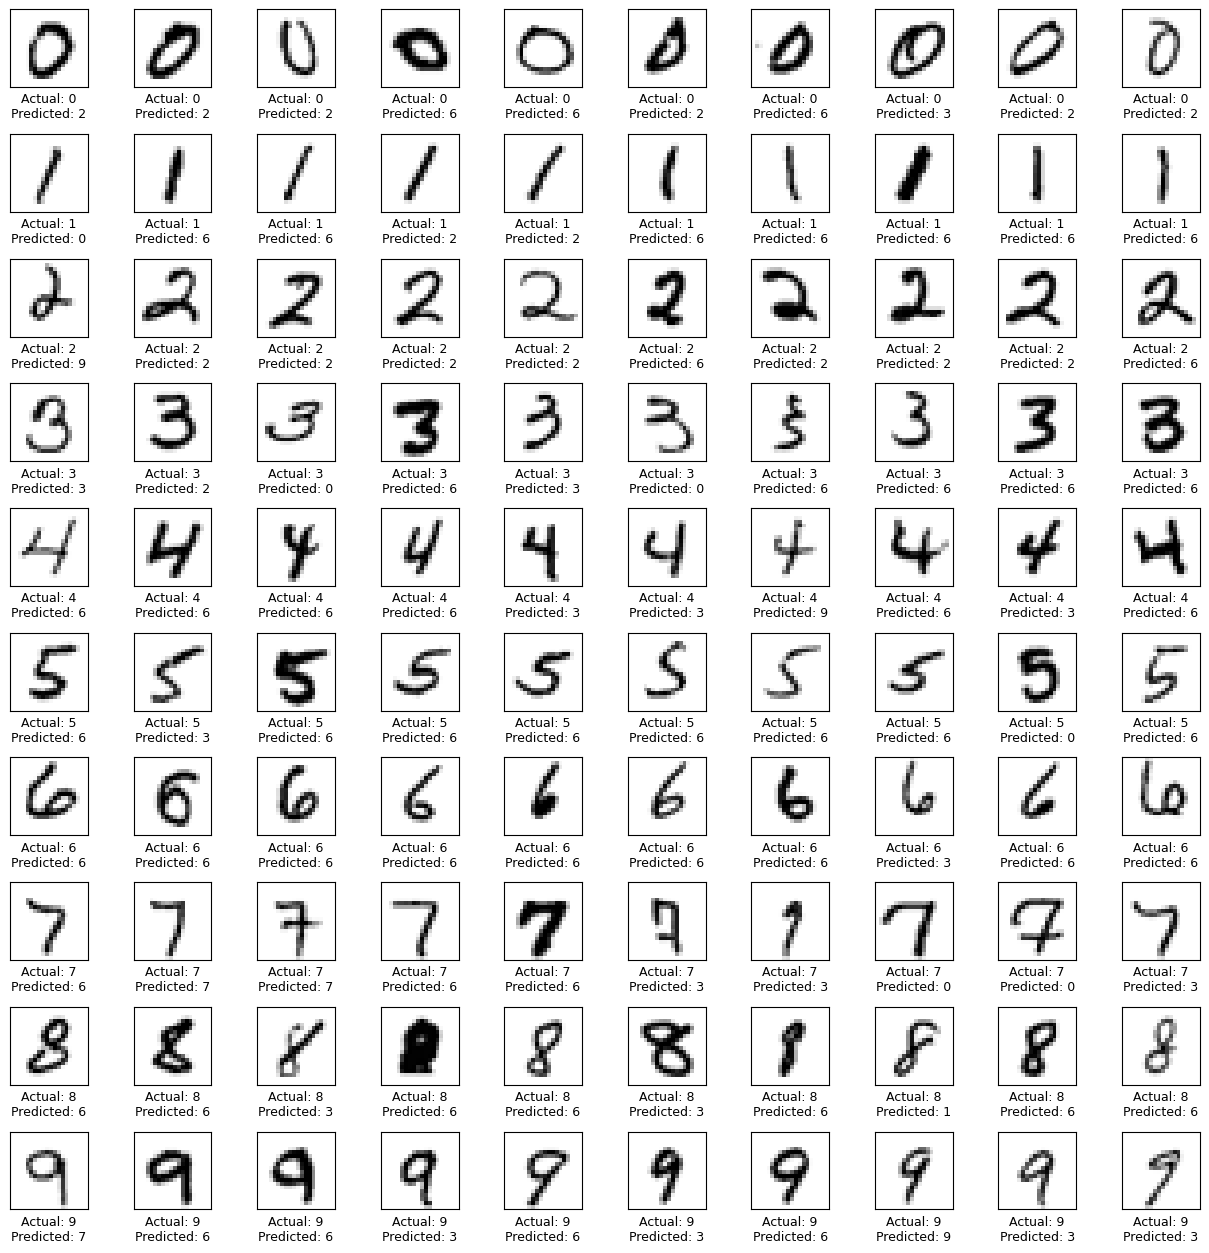

In [46]:
def main():
    # Paths to the dataset files
    train_image_path = 'data/train-images-idx3-ubyte'
    train_label_path = 'data/train-labels-idx1-ubyte'
    test_image_path = 'data/t10k-images-idx3-ubyte'
    test_label_path = 'data/t10k-labels-idx1-ubyte'

    data_handler = DataHandler(train_image_path, train_label_path, test_image_path, test_label_path)

    train_images_subset, train_labels_subset = data_handler.load_data_subset(num_samples_per_digit=10)

    test_images_subset, test_labels_subset = data_handler.load_data_subset(num_samples_per_digit=10)

    learning_rates = [0.001, 0.01, 0.1]
    epoch_options = [50, 100, 200]

    best_accuracy = 0
    best_model = None
    best_predictions = None
    best_lr = 0
    best_epochs = 0

    for lr in learning_rates:
        for epochs in epoch_options:
            print(f"\nTraining with learning rate: {lr} and epochs: {epochs}")
            perceptron = Perceptron(num_inputs=400, num_neurons=10)
            trainer = Trainer(perceptron, learning_rate=lr)
            trainer.train(train_images_subset, train_labels_subset, epochs=epochs)

            tester = Tester(perceptron)
            test_predictions = tester.test(test_images_subset)
            accuracy = np.mean(np.array(test_predictions) == test_labels_subset)
            print(f"Test Accuracy: {accuracy * 100:.2f}%")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = perceptron
                best_predictions = test_predictions
                best_lr = lr
                best_epochs = epochs

    # Displaying results of the best model
    print(f"\nBest Model - Learning Rate: {best_lr}, Epochs: {best_epochs}, Accuracy: {best_accuracy * 100:.2f}%")
    visualizer = ImageVisualizer()
    print("Displaying the test images with predictions of the best model...")
    visualizer.display_images_with_predictions(test_images_subset, test_labels_subset, best_predictions, image_shape=(20, 20))

if __name__ == "__main__":
    main()
